# Initial EDA and Modeling

Connor Capitolo, David Assaraf, Tale Lokevenec

In [ ]:
import os
from datetime import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# need to make sure that .csv in your Drive, not the SharedWithMe one; ref: https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
#os.listdir('/content/gdrive/MyDrive/') # ['Colab Notebooks', 'btcusdt_exchange.csv']

In [ ]:
# Tale's location in Drive
btcusdt_df = pd.read_csv('/content/gdrive/MyDrive/AC215_data/btcusdt_data.csv', index_col=0)
# Connor's location in Drive
# btcusdt_df = pd.read_csv('/content/gdrive/MyDrive/btcusdt_exchange.csv', index_col=0)
display(btcusdt_df.head())
display(btcusdt_df.tail())

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Open Time,Open Price,High price,Low Price,Close Price,Volume Traded,Close Time,Quote asset Volume,Number of Trades,Taker buy base asset volume,Taker buy quote asset volume,NA
0,1502942400000,4261.48,4261.48,4261.48,4261.48,1.775183,1502942459999,7564.906851,3,0.075183,320.390851,7960.540180
1,1502942460000,4261.48,4261.48,4261.48,4261.48,0.000000,1502942519999,0.000000,0,0.000000,0.000000,7960.452630
2,1502942520000,4280.56,4280.56,4280.56,4280.56,0.261074,1502942579999,1117.542921,2,0.261074,1117.542921,7960.375295
3,1502942580000,4261.48,4261.48,4261.48,4261.48,0.012008,1502942639999,51.171852,3,0.012008,51.171852,7960.375295
4,1502942640000,4261.48,4261.48,4261.48,4261.48,0.140796,1502942699999,599.999338,1,0.140796,599.999338,7960.375295


,Open Time,Open Price,High price,Low Price,Close Price,Volume Traded,Close Time,Quote asset Volume,Number of Trades,Taker buy base asset volume,Taker buy quote asset volume,NA
2188599,1634767200000,65807.50,65812.53,65602.58,65624.72,50.29628,1634767259999,3.304131e+06,1373,23.69428,1.556025e+06,0.0
2188600,1634767260000,65617.76,65685.03,65462.00,65635.98,192.96218,1634767319999,1.264544e+07,6838,51.73500,3.391136e+06,0.0
2188601,1634767320000,65629.47,65639.14,65590.42,65608.13,17.87520,1634767379999,1.172816e+06,876,9.31851,6.113667e+05,0.0
2188602,1634767380000,65608.14,65741.55,65601.91,65650.01,31.35528,1634767439999,2.058710e+06,1081,21.75019,1.427981e+06,0.0
2188603,1634767440000,65650.01,65654.77,65650.00,65650.01,0.49179,1634767499999,3.228648e+04,16,0.30071,1.974181e+04,0.0


In [ ]:
# PROVIDING EXPLANATIONS OF THE FEATURES
from prettytable import PrettyTable

feature_name = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "Qupte Asset Volume", "Number of Trades", "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"]
explanation = ["Candle Open Time", "Open Price in Quote (Secondary) Asset Units", "High Price in Quote (Secondary) Asset Units", "Low Price in Quote (Secondary) Asset Units", "Close Price in Quote (Secondary) Asset Units", "Total Trade Volume in Base (Primary) Asset Units", "Candle Close Time", "Total Trade Volume in Quote (Secondary Asset Units", "Total Number of Trades", "Taker (Matching Existing Order) Buy Base Asset Volume", "Taker (Mathcing Existing Order) Buy Quote Asset Volume", "Safe to Ignore"]
table = PrettyTable()
table.field_names = ["Candle Feature", "Description"]
for el1, el2 in zip(feature_name, explanation):
  table.add_row([el1, el2])
print(table)

+------------------------------+--------------------------------------------------------+
|        Candle Feature        |                      Description                       |
+------------------------------+--------------------------------------------------------+
|          Open Time           |                    Candle Open Time                    |
|             Open             |      Open Price in Quote (Secondary) Asset Units       |
|             High             |      High Price in Quote (Secondary) Asset Units       |
|             Low              |       Low Price in Quote (Secondary) Asset Units       |
|            Close             |      Close Price in Quote (Secondary) Asset Units      |
|            Volume            |    Total Trade Volume in Base (Primary) Asset Units    |
|          Close Time          |                   Candle Close Time                    |
|      Qupte Asset Volume      |   Total Trade Volume in Quote (Secondary Asset Units   |
|       Nu

In [ ]:
display(btcusdt_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Open Time,2188604.0,1.568917e+12,3.804581e+10,1.502942e+12,1.536002e+12,1.568959e+12,1.601858e+12,1.634767e+12
Open Price,2188604.0,1.559272e+04,1.539757e+04,2.830000e+03,6.632165e+03,9.138030e+03,1.379851e+04,6.693001e+04
High price,2188604.0,1.560465e+04,1.540977e+04,2.830000e+03,6.635780e+03,9.142340e+03,1.381000e+04,6.700000e+04
Low Price,2188604.0,1.558064e+04,1.538549e+04,2.817000e+03,6.628855e+03,9.133480e+03,1.378106e+04,6.690101e+04
Close Price,2188604.0,1.559273e+04,1.539762e+04,2.817000e+03,6.632147e+03,9.138010e+03,1.379861e+04,6.693001e+04
Volume Traded,2188604.0,3.539101e+01,5.822797e+01,0.000000e+00,9.817536e+00,2.039679e+01,3.988633e+01,3.564139e+03
Close Time,2188604.0,1.568917e+12,3.804581e+10,1.502942e+12,1.536002e+12,1.568959e+12,1.601858e+12,1.634767e+12
Quote asset Volume,2188604.0,6.832094e+05,1.563783e+06,0.000000e+00,7.387065e+04,1.988054e+05,6.357749e+05,1.136863e+08
Number of Trades,2188604.0,5.060226e+02,7.825280e+02,0.000000e+00,1.080000e+02,2.420000e+02,6.250000e+02,4.452900e+04
Taker buy base asset volume,2188604.0,1.764021e+01,3.039752e+01,0.000000e+00,4.515430e+00,9.745415e+00,1.972551e+01,2.177455e+03


In [ ]:
display(btcusdt_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2188604 entries, 0 to 2188603
Data columns (total 12 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Open Time                     int64  
 1   Open Price                    float64
 2   High price                    float64
 3   Low Price                     float64
 4   Close Price                   float64
 5   Volume Traded                 float64
 6   Close Time                    int64  
 7   Quote asset Volume            float64
 8   Number of Trades              int64  
 9   Taker buy base asset volume   float64
 10  Taker buy quote asset volume  float64
 11  NA                            float64
dtypes: float64(9), int64(3)
memory usage: 217.1 MB


None

In [ ]:
display(btcusdt_df.isnull().sum())

Open Time                       0
Open Price                      0
High price                      0
Low Price                       0
Close Price                     0
Volume Traded                   0
Close Time                      0
Quote asset Volume              0
Number of Trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
NA                              0
dtype: int64

In [ ]:
# https://www.programiz.com/python-programming/datetime/timestamp-datetime
now = time.time()
print(now)
dt_object = datetime.fromtimestamp(now)

print("dt_object =", dt_object)
print("type(dt_object) =", type(dt_object))

1635297262.4753509
dt_object = 2021-10-27 01:14:22.475351
type(dt_object) = <class 'datetime.datetime'>


In [ ]:
btcusdt_df = btcusdt_df.drop(['NA'], axis = 1)
btcusdt_df = btcusdt_df.assign(Date = lambda x: x['Open Time']/1000)
btcusdt_df['Date'] = pd.to_datetime(btcusdt_df['Date'], unit = 's')
btcusdt_df['Year'] = pd.DatetimeIndex(btcusdt_df['Date']).year
btcusdt_df['Month'] = pd.DatetimeIndex(btcusdt_df['Date']).month
btcusdt_df['Day of Week'] = pd.DatetimeIndex(btcusdt_df['Date']).dayofweek

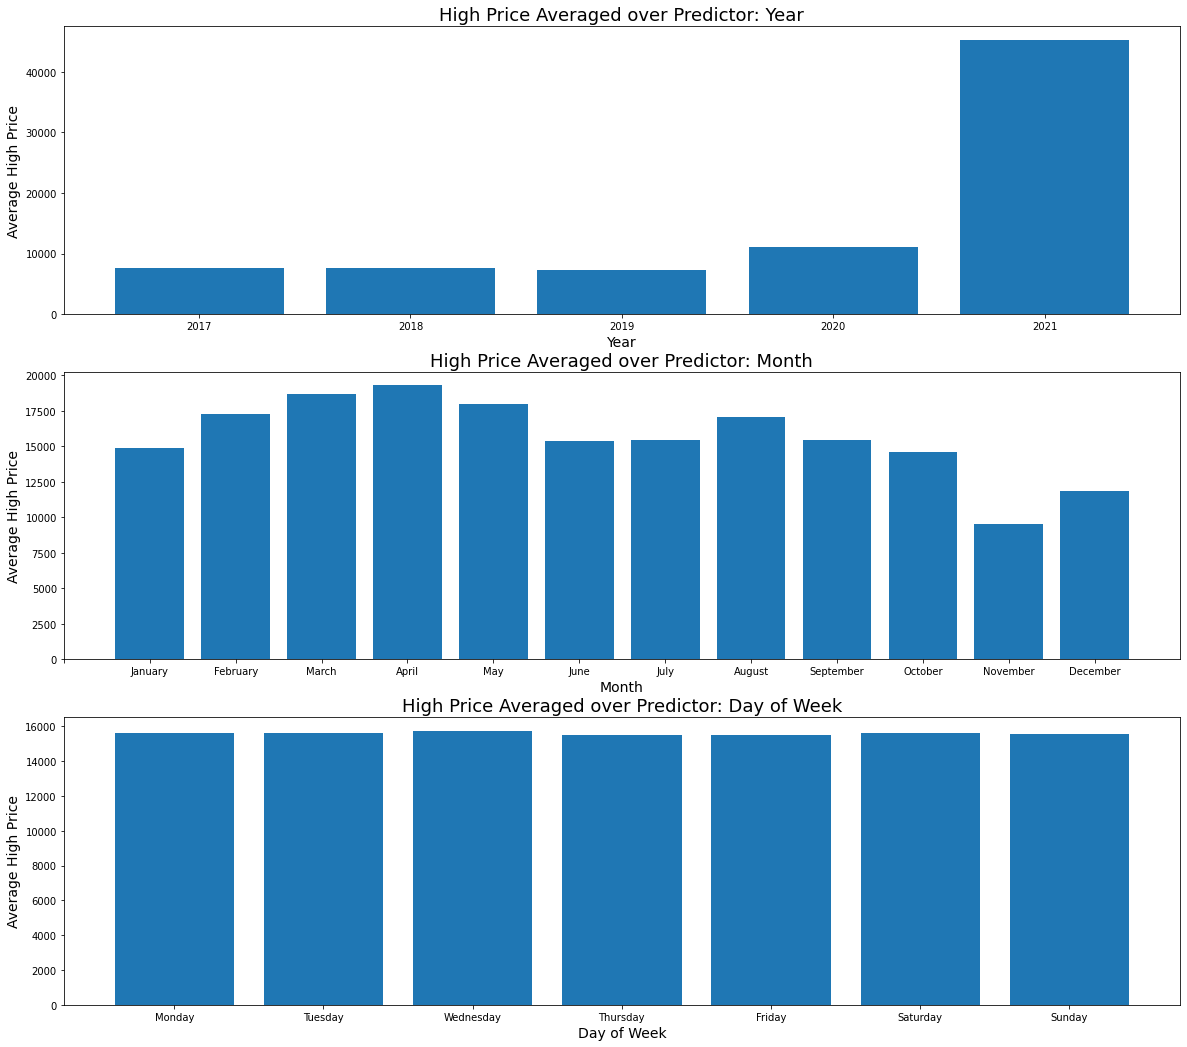

In [ ]:
# Plotting the mean of aggregated data by features: Year, Month, Day of Week
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (20,18))
months = ['', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekdays = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for idx, agg_val in enumerate(['Year', 'Month', 'Day of Week']):
  to_plot = btcusdt_df.groupby(by = agg_val).mean()
  ax[idx].bar(to_plot.index, to_plot['High price'])
  ax[idx].set_title(f'High Price Averaged over Predictor: {agg_val}', fontsize = 18)
  ax[idx].set_xlabel(agg_val, fontsize = 14)
  ax[idx].set_ylabel('Average High Price', fontsize = 14)
  if agg_val == 'Month':
    ax[idx].set_xticks(np.arange(13))   
    ax[idx].set_xticklabels(months)
  if agg_val == 'Day of Week':
    ax[idx].set_xticklabels(weekdays)



In [ ]:
aggregated_day = btcusdt_df.groupby(pd.Grouper(key='Date', axis=0, freq='D')).mean().reset_index()
max_price = aggregated_day.nlargest(2, 'High price')

In [ ]:
btcusdt_df.head()

,Open Time,Open Price,High price,Low Price,Close Price,Volume Traded,Close Time,Quote asset Volume,Number of Trades,Taker buy base asset volume,Taker buy quote asset volume,Date,Year,Month,Day of Week
0,1502942400000,4261.48,4261.48,4261.48,4261.48,1.775183,1502942459999,7564.906851,3,0.075183,320.390851,2017-08-17 04:00:00,2017,8,3
1,1502942460000,4261.48,4261.48,4261.48,4261.48,0.000000,1502942519999,0.000000,0,0.000000,0.000000,2017-08-17 04:01:00,2017,8,3
2,1502942520000,4280.56,4280.56,4280.56,4280.56,0.261074,1502942579999,1117.542921,2,0.261074,1117.542921,2017-08-17 04:02:00,2017,8,3
3,1502942580000,4261.48,4261.48,4261.48,4261.48,0.012008,1502942639999,51.171852,3,0.012008,51.171852,2017-08-17 04:03:00,2017,8,3
4,1502942640000,4261.48,4261.48,4261.48,4261.48,0.140796,1502942699999,599.999338,1,0.140796,599.999338,2017-08-17 04:04:00,2017,8,3


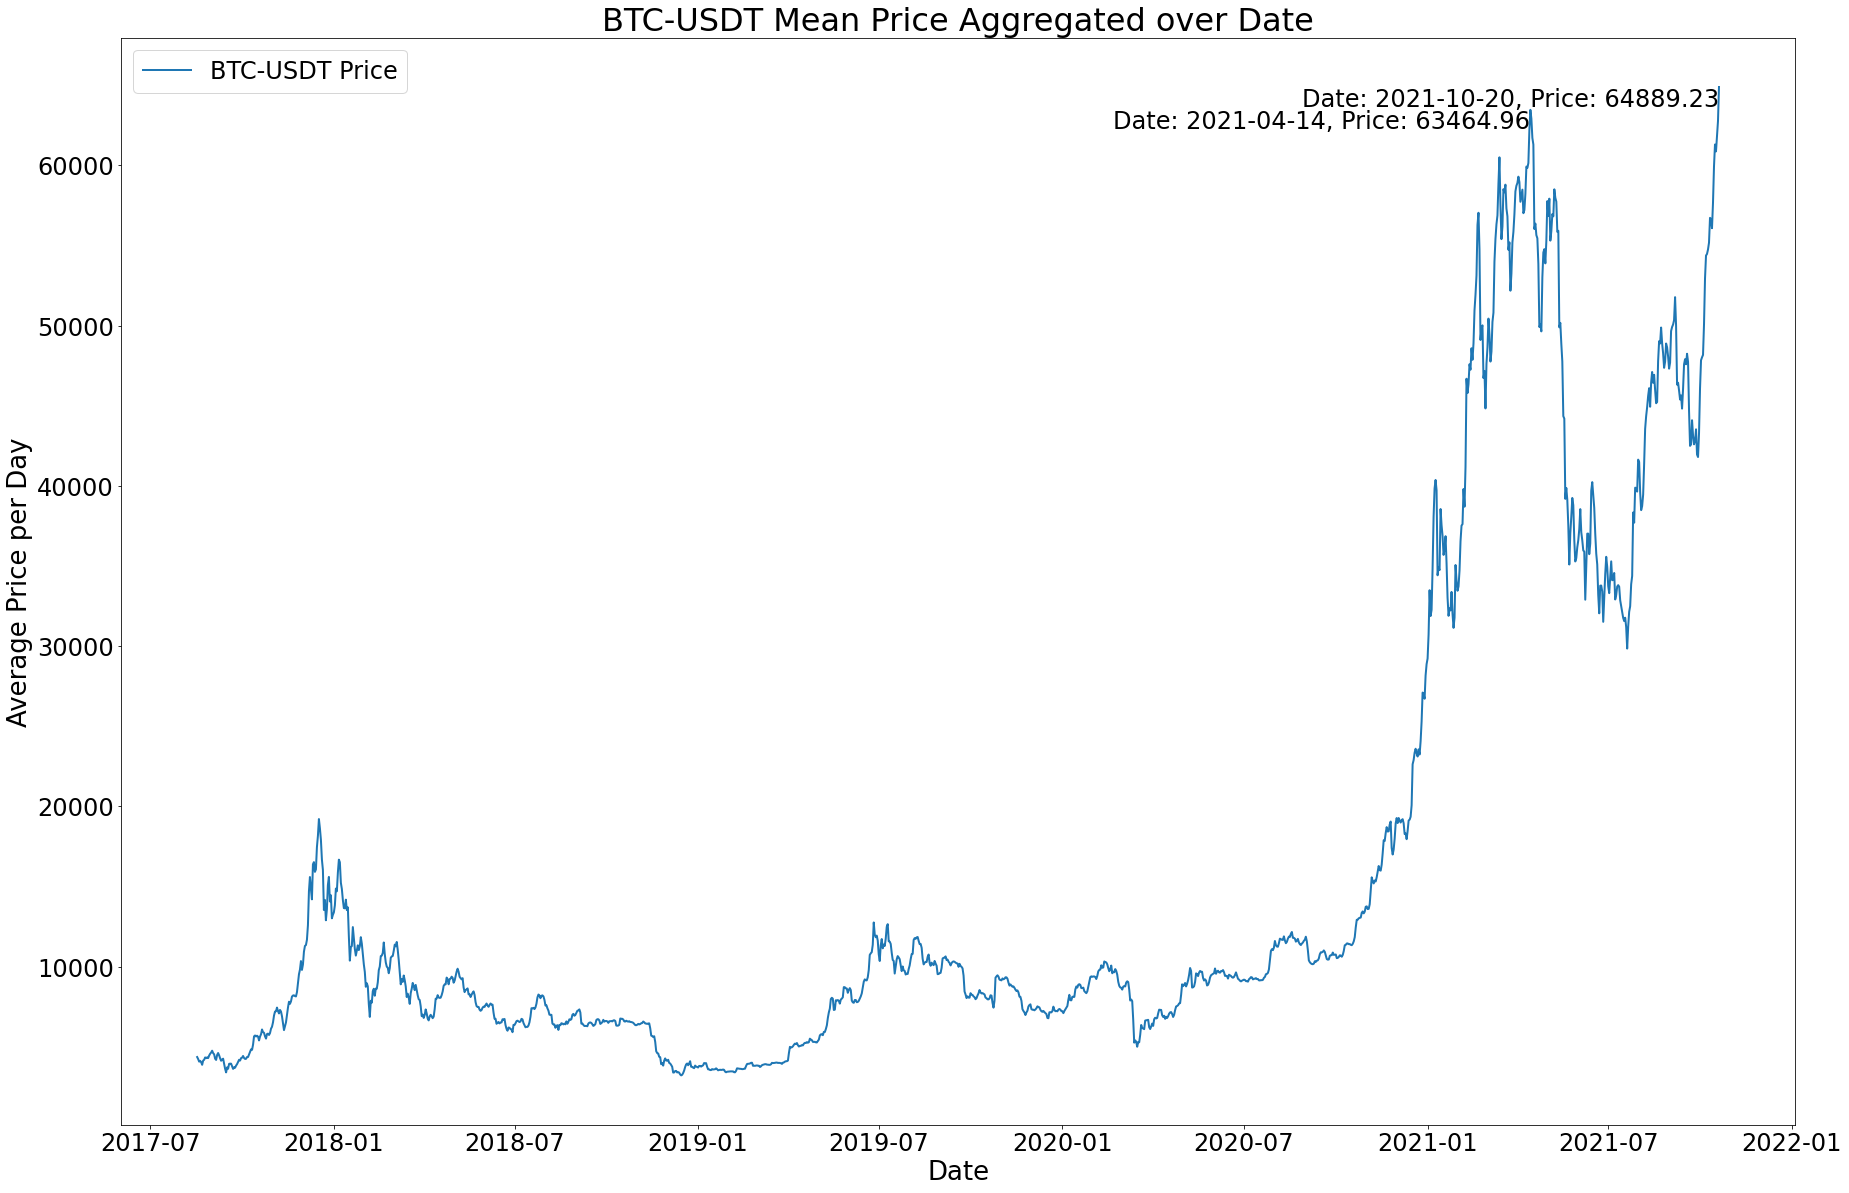

In [ ]:
# EDA of the high price traded, mean value per day. This is very importan to understand the market
fig, ax = plt.subplots(figsize = (30,20))
ax.plot(aggregated_day.Date, aggregated_day['High price'], lw = 2, label='BTC-USDT Price')
for idx, val in zip(max_price.Date.dt.date, max_price['High price']):
  ax.annotate(f'Date: {idx}, Price: {val:.2f}', (idx, val), size = 24, ha='right', va='top')
ax.set_xlabel('Date', fontsize = 26)
ax.set_ylabel('Average Price per Day', fontsize = 26)
ax.set_title('BTC-USDT Mean Price Aggregated over Date', fontsize = 32)
ax.legend(loc = 'upper left', fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=24)

Reactions to figure above:

- COVID doesn't seem to have any crazy effect, if anything price started increasing after COVID. We observe huge tank in the price around July 2021, but that was a period of extremely high uncertainty of the market and all the currencies were dropping in price.

In [ ]:
trading_vol = aggregated_day.nlargest(5, 'Volume Traded')

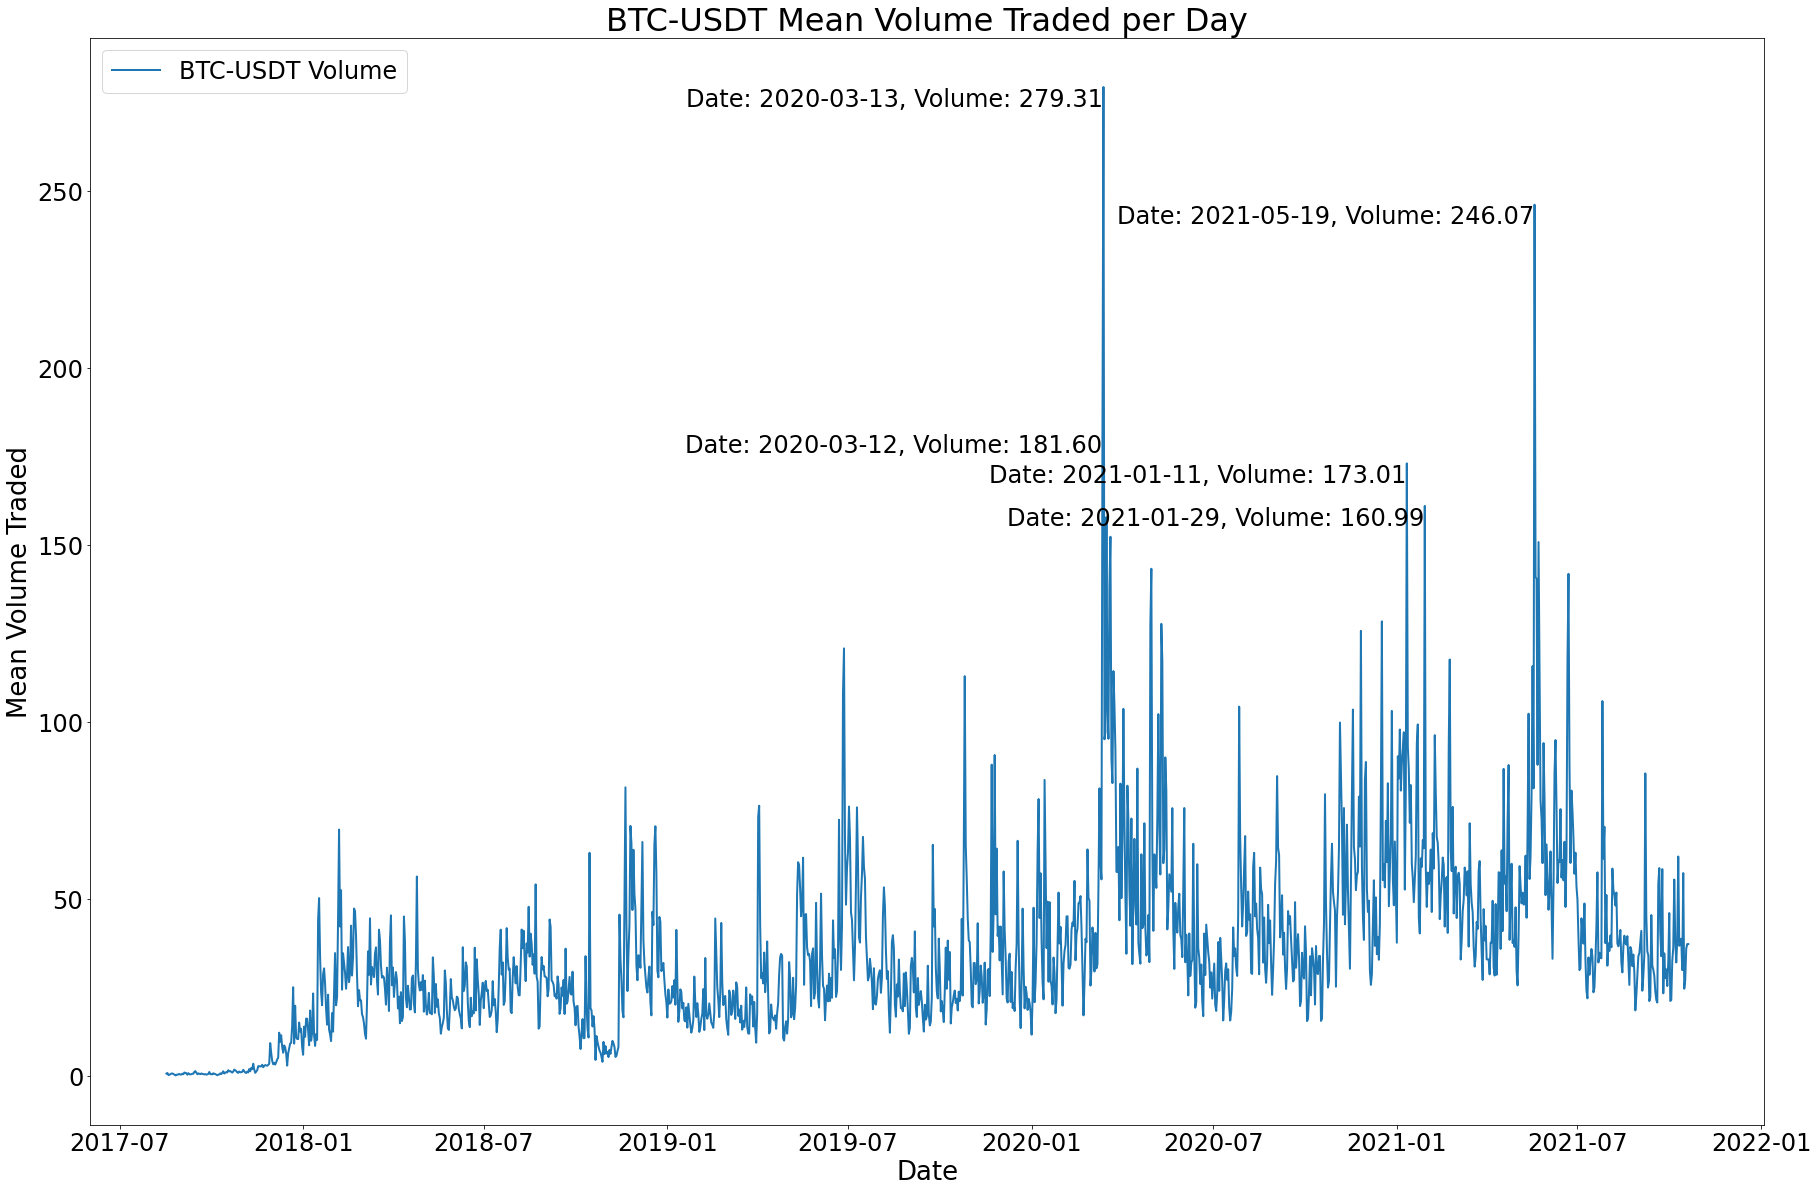

In [ ]:
# EDA of the total volume traded, mean value per day. This is very important to understand the market

fig, ax = plt.subplots(figsize = (30,20))
ax.plot(aggregated_day.Date, aggregated_day['Volume Traded'], lw = 2, label='BTC-USDT Volume')
for idx, val in zip(trading_vol.Date.dt.date, trading_vol['Volume Traded']):
  ax.annotate(f'Date: {idx}, Volume: {val:.2f}', (idx, val), size = 24, ha='right', va='top')
ax.set_xlabel('Date', fontsize = 26)
ax.set_ylabel('Mean Volume Traded', fontsize = 26)
ax.set_title('BTC-USDT Mean Volume Traded per Day', fontsize = 32)
ax.legend(loc = 'upper left', fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=24)

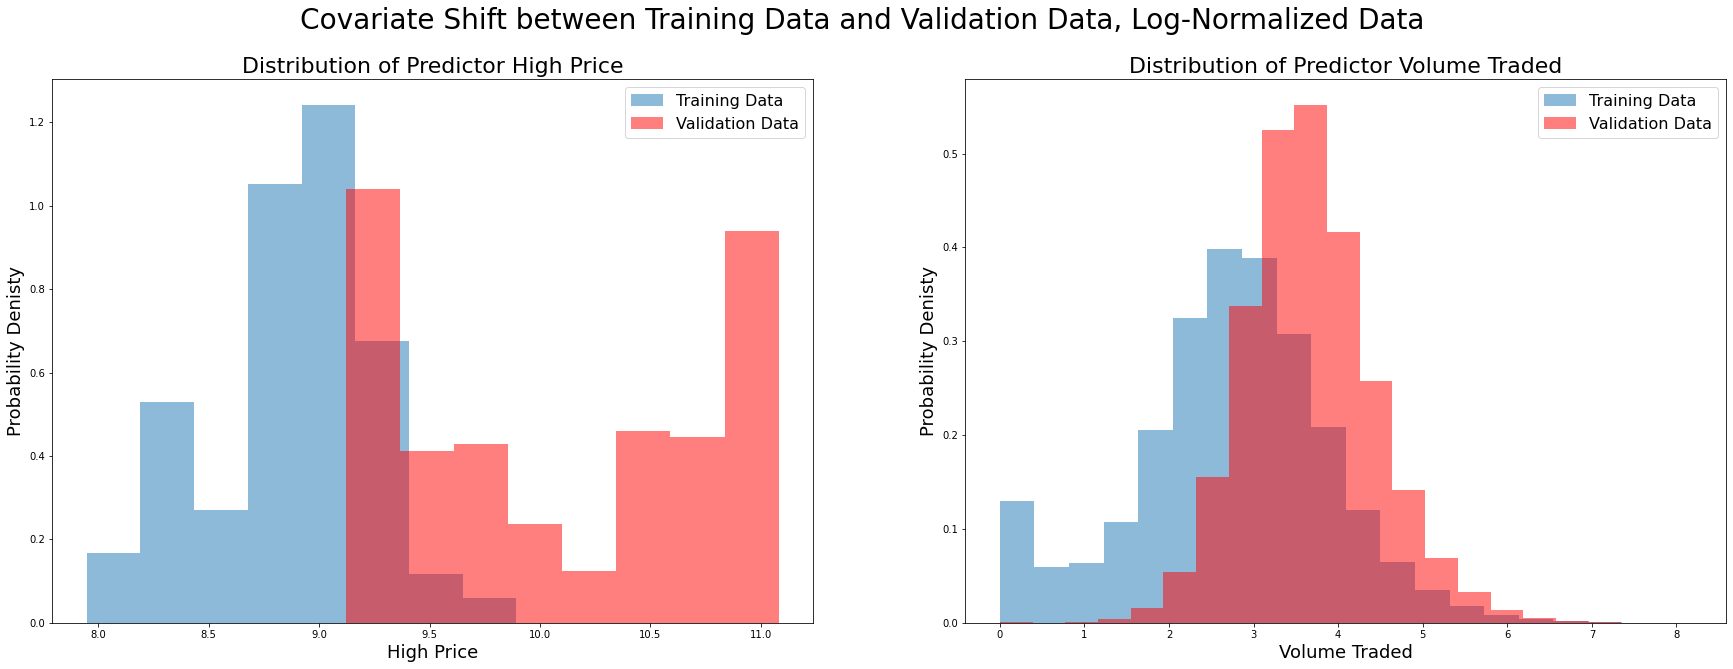

In [ ]:
# EDA on the distribution shifts
n = len(btcusdt_df)
train_df = btcusdt_df[0:int(n*0.7)]
val_df = btcusdt_df[int(n*0.7):int(n*0.9)]
test_df = btcusdt_df[int(n*0.9):]
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
fig.suptitle('Covariate Shift between Training Data and Validation Data, Log-Normalized Data', fontsize = 28)
#hist_tr, bins_tr = np.histogram(train_df['High price'].values, bins = 10)
#hist_v, bins_v = np.histogram(val_df['High price'].values, bins = 10)
#logbins_tr = np.logspace(np.log10(bins_tr[0]+1), np.log10(bins_tr[-1]+1), len(bins_tr))
#logbins_v = np.logspace(np.log10(bins_v[0]+1), np.log10(bins_v[-1]+1), len(bins_v))
ax[0].hist(np.log(train_df['High price'].values+1), bins = 8, alpha = 0.5, density = True, label = 'Training Data');
ax[0].hist(np.log(val_df['High price'].values+1), bins = 8, alpha= 0.5, density = True, color = 'red', label = 'Validation Data');
ax[0].legend(loc = 'best', fontsize = 16)
#ax[0].set_xscale('log')
ax[0].set_xlabel('High Price', fontsize = 18)
ax[0].set_ylabel('Probability Denisty', fontsize = 18)
ax[0].set_title('Distribution of Predictor High Price', fontsize = 22)

#hist_tr1, bins_tr1 = np.histogram(train_df['Volume Traded'].values, bins = 10)
#hist_v1, bins_v1 = np.histogram(val_df['Volume Traded'].values, bins = 10)
#logbins_tr1 = np.logspace(np.log10(bins_tr1[0]+1), np.log10(bins_tr1[-1]+1), len(bins_tr1))
#logbins_v1 = np.logspace(np.log10(bins_v1[0]+1), np.log10(bins_v1[-1]+1), len(bins_v1))
ax[1].hist(np.log(train_df['Volume Traded'].values+1), bins = 20, alpha = 0.5, density = True, label = 'Training Data');
ax[1].hist(np.log(val_df['Volume Traded'].values+1), bins = 20, alpha= 0.5, density = True, color = 'red', label = 'Validation Data');
ax[1].legend(loc = 'best', fontsize = 16)
#ax[1].set_xscale('log')
ax[1].set_xlabel('Volume Traded', fontsize = 18)
ax[1].set_ylabel('Probability Denisty', fontsize = 18)
ax[1].set_title('Distribution of Predictor Volume Traded', fontsize = 22);

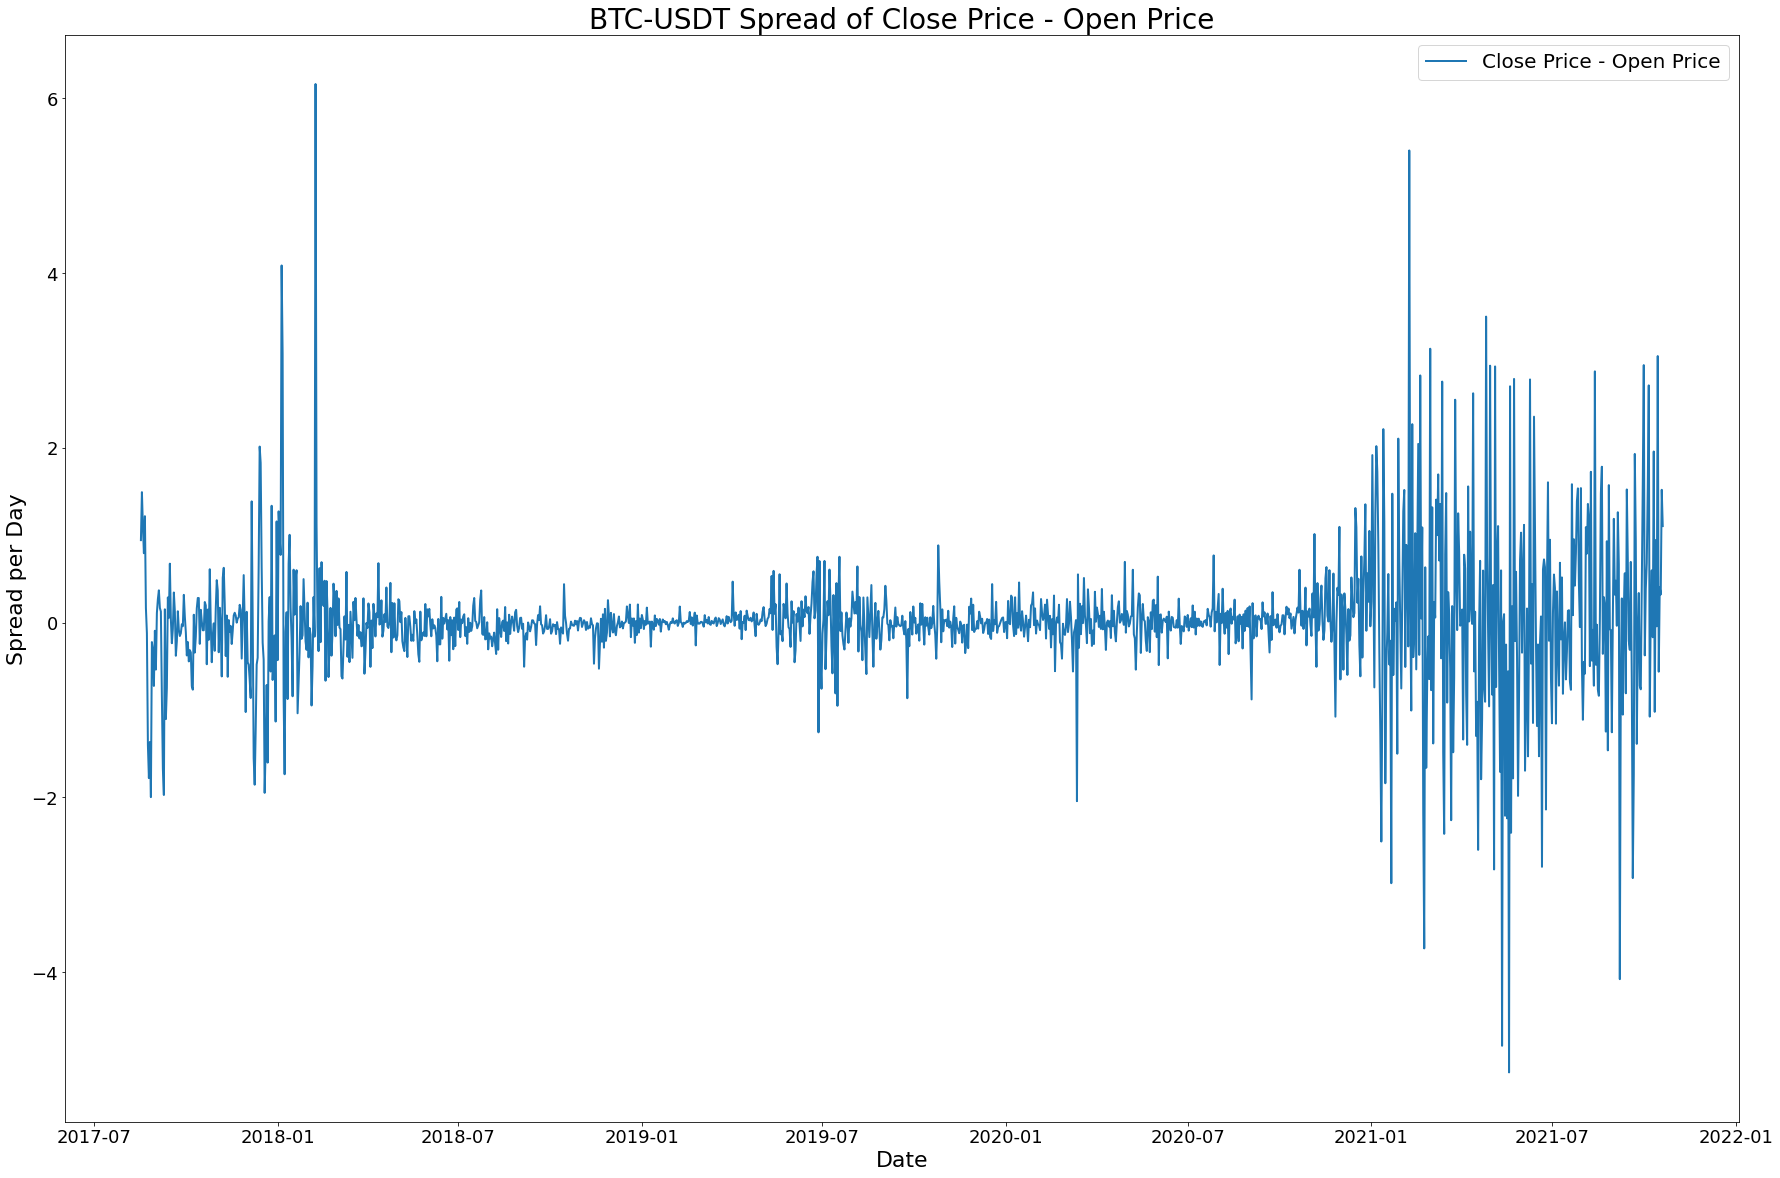

In [ ]:
# EDA on the spread: Close Price - Open Price 
fig, ax = plt.subplots(figsize = (30,20))
ax.plot(aggregated_day.Date, aggregated_day['Close Price']-aggregated_day['Open Price'], lw = 2, label = 'Close Price - Open Price')
ax.set_xlabel('Date', fontsize = 22)
ax.set_ylabel('Spread per Day', fontsize = 22)
ax.set_title('BTC-USDT Spread of Close Price - Open Price', fontsize = 28)
ax.legend(loc = 'best', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=18)

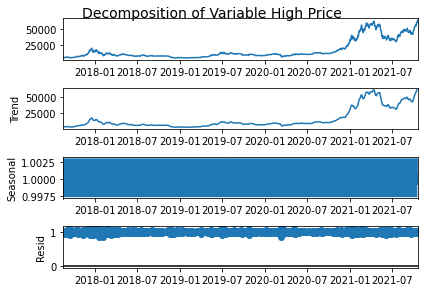

In [ ]:
# EDA on the decomposition into trend & seasonality for High Price
from statsmodels.tsa.seasonal import seasonal_decompose
hp_results = seasonal_decompose(pd.Series(aggregated_day['High price'].values, index = aggregated_day.Date), model = 'multiplicative')
fig = hp_results.plot()
fig.suptitle('Decomposition of Variable High Price', va = 'center', fontsize = 14)
plt.show();

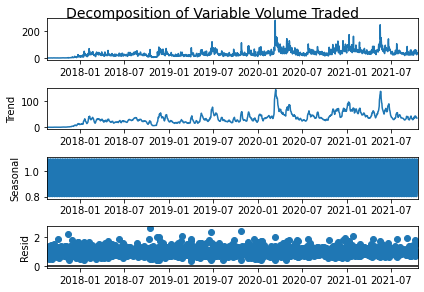

In [ ]:
# EDA on the decomposition into trend & seasonality for Volume Traded
vt_results = seasonal_decompose(pd.Series(aggregated_day['Volume Traded'].values, index = aggregated_day.Date), model = 'multiplicative')
fig = vt_results.plot()
fig.suptitle('Decomposition of Variable Volume Traded', va = 'center', fontsize = 14)
plt.show();

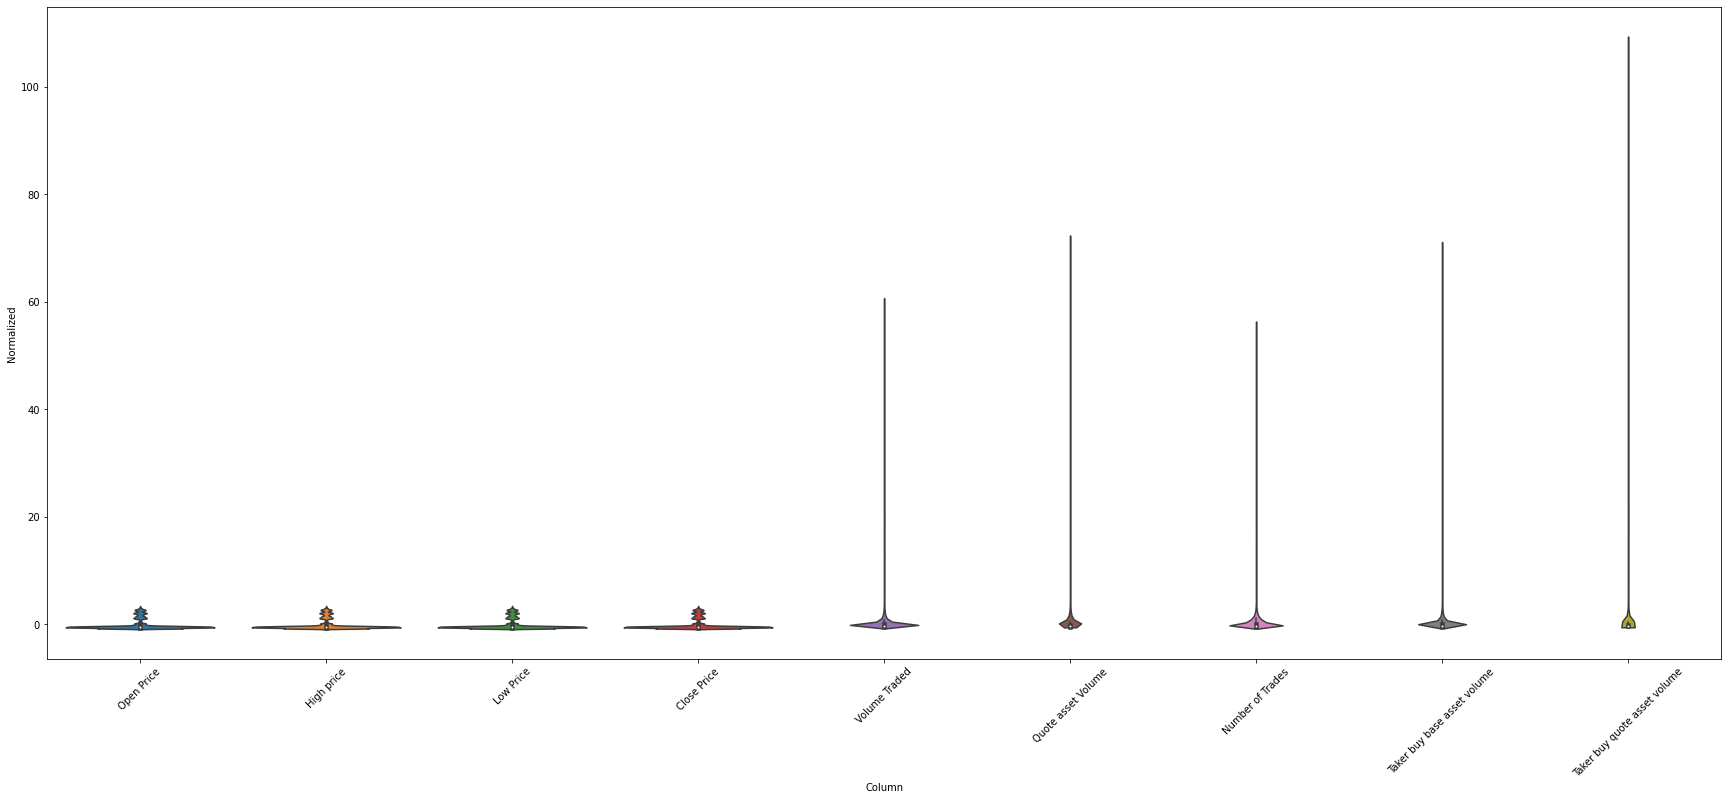

In [ ]:
to_standardize = btcusdt_df.drop(['Open Time', 'Close Time', 'Date', 'Year', 'Month', 'Day of Week'], axis = 1)
mean_ = to_standardize.mean()
std_ = to_standardize.std()
stnadardized = (to_standardize - mean_)/std_
stnadardized = stnadardized.melt(var_name='Column', value_name='Normalized')

fig = plt.figure(figsize=(30, 12))
ax = sns.violinplot(x='Column', y='Normalized', data=stnadardized)
_ = ax.set_xticklabels(to_standardize.keys(), rotation=45)

Reactions
- no missing data
- could do some sort of encoding for `Number of Trades` since it's discrete value (it is discrete but not categorical right?)

# Preliminary Modeling Decisions Just To Get a Working model based on tutorial:
- remove `NA` column
- remove `Open Price` since same as the previous rows' `Close Price` (don't want to introduce data leakage into model)
  - in future: *someone look up best way to handle time*
      - could use daily and yearly periodicity for `Open Time` similar to tutorial


In [ ]:
# Tale's location in Drive
btcusdt_df1 = pd.read_csv('/content/gdrive/MyDrive/AC215_data/btcusdt_data.csv', index_col=0)
# Connor's location in Drive
# btcusdt_df = pd.read_csv('/content/gdrive/MyDrive/btcusdt_exchange.csv', index_col=0)
print(f'Shape of original dataset: {btcusdt_df1.shape}')
prelim_modeling_df = btcusdt_df1.drop(['Close Time', 'Open Time','NA'], axis = 1)
print(f'Shape after removal of unncessary columns: {prelim_modeling_df.shape}')

Shape of original dataset: (2188604, 12)
Shape after removal of unncessary columns: (2188604, 9)


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
prelim_modeling_df.head()

,Open Price,High price,Low Price,Close Price,Volume Traded,Quote asset Volume,Number of Trades,Taker buy base asset volume,Taker buy quote asset volume
0,4261.48,4261.48,4261.48,4261.48,1.775183,7564.906851,3,0.075183,320.390851
1,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0,0.000000,0.000000
2,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921,2,0.261074,1117.542921
3,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852,3,0.012008,51.171852
4,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338,1,0.140796,599.999338


Split the data

In [ ]:
column_indices = {name: i for i, name in enumerate(prelim_modeling_df.columns)}

n = len(prelim_modeling_df)
train_df = prelim_modeling_df[0:int(n*0.7)]
val_df = prelim_modeling_df[int(n*0.7):int(n*0.9)]
test_df = prelim_modeling_df[int(n*0.9):]

num_features = prelim_modeling_df.shape[1]

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1532022, 9)
(437721, 9)
(218861, 9)


Noramlize the data

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Peak at distributions of features

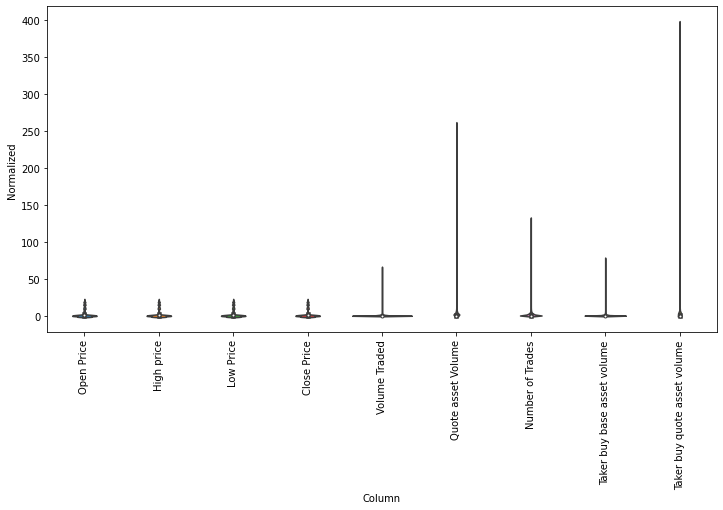

In [ ]:
df_std = (prelim_modeling_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(prelim_modeling_df.keys(), rotation=90)

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open Price,1532022.0,-2.008298e-13,1.0,-1.811033,-0.576700,-0.047839,0.607741,4.530035
High price,1532022.0,3.328820e-12,1.0,-1.810435,-0.576450,-0.048488,0.606303,4.534628
Low Price,1532022.0,-3.300387e-12,1.0,-1.816539,-0.577169,-0.047170,0.609249,4.534661
Close Price,1532022.0,-1.970853e-13,1.0,-1.815886,-0.576752,-0.047871,0.607728,4.533279
Volume Traded,1532022.0,-1.818778e-14,1.0,-0.535737,-0.399419,-0.247159,0.044119,66.276202
Quote asset Volume,1532022.0,4.506021e-15,1.0,-0.514619,-0.401110,-0.247080,0.047454,81.229773
Number of Trades,1532022.0,2.380523e-13,1.0,-0.700872,-0.452456,-0.254920,0.131173,63.034414
Taker buy base asset volume,1532022.0,1.966230e-14,1.0,-0.523241,-0.401420,-0.252511,0.042154,78.516982
Taker buy quote asset volume,1532022.0,-2.874625e-14,1.0,-0.500539,-0.398686,-0.252497,0.044006,103.492297


In [ ]:
! pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 5.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
btcusdt_df_dropped = btcusdt_df.drop(['Close Time', 'Open Time','Date', 'Year', 'Month', 'Day of Week'], axis = 1)
btcusdt_df_normalized = (btcusdt_df_dropped - train_mean) /train_std

In [ ]:
btcusdt_df_normalized.head()

,Open Price,High price,Low Price,Close Price,Volume Traded,Quote asset Volume,Number of Trades,Taker buy base asset volume,Taker buy quote asset volume
0,-1.274943,-1.275164,-1.274714,-1.274929,-0.502460,-0.497202,-0.691894,-0.520512,-0.499113
1,-1.274943,-1.275164,-1.274714,-1.274929,-0.535737,-0.514619,-0.700872,-0.523241,-0.500539
2,-1.267797,-1.268030,-1.267557,-1.267783,-0.530843,-0.512046,-0.694887,-0.513765,-0.495565
3,-1.274943,-1.275164,-1.274714,-1.274929,-0.535512,-0.514501,-0.691894,-0.522806,-0.500311
4,-1.274943,-1.275164,-1.274714,-1.274929,-0.533098,-0.513237,-0.697880,-0.518131,-0.497868


In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

class ExponentialSmoothing:
  '''This clas implement different Exponential Smoothing techniques
     Input params:
     - n_pred = numer of future predictions
     - window = training window; used for model training
     - data = df used for the model (note: the df should contain both tran and val data)
     - variable = variable used for prediction'''
  def __init__(self, n_pred_val, n_pred_test, window, data, variable):
    self.n_pred_val = n_pred_val
    self.n_pred_test = n_pred_test
    self.window = window
    self.d = data
    self.data = data[variable].values
    self.len_data = len(self.data)

  def SimpleExpSmoothing_(self):
    forecasts = []
    start_time = time.time()
    for idx in range(self.n_pred_val+self.n_pred_test):
      if idx%10000 == 0:
        print(idx, time.time()-start_time)
      fitting_data = self.data[(self.len_data-self.n_pred_val-self.n_pred_test-self.window+idx):(self.len_data-self.n_pred_val-self.n_pred_test+idx)]
      fit_ses = SimpleExpSmoothing(fitting_data, initialization_method='estimated').fit()
      forecasts.append(fit_ses.forecast(1)[0])
    return forecasts

  def HoltAdditive_(self):
    forecasts = []
    for idx in range(self.n_pred_val+self.n_pred_test):
      fitting_data = self.data[(self.len_data-self.n_pred_val-self.n_pred_test-self.window+idx):(self.len_data-self.n_pred_val-self.n_pred_test+idx)]
      fit_holt = Holt(fitting_data, initialization_method='estimated').fit()
      forecasts.append(fit_holt.forecast(1)[0])
    return forecasts

  def HoltExponential_(self):
    forecasts = []
    for idx in range(self.n_pred_val+self.n_pred_test):
      fitting_data = self.data[(self.len_data-self.n_pred_val-self.n_pred_test-self.window+idx):(self.len_data-self.n_pred_val-self.n_pred_test+idx)]
      fit_holt_exp = Holt(fitting_data, exponential=True, initialization_method='estimated').fit()
      forecasts.append(fit_holt_exp.forecast(1)[0])
    return forecasts

  def HoltADamped_(self):
    forecasts = []
    for idx in range(self.n_pred_val+self.n_pred_test):
      fitting_data = self.data[(self.len_data-self.n_pred_val-self.n_pred_test-self.window+idx):(self.len_data-self.n_pred_val-self.n_pred_test+idx)]
      fit_holt_adamped = Holt(fitting_data, damped_trend=True, initialization_method='estimated').fit(damping_trend=0.98)
      forecasts.append(fit_holt_adamped.forecast(1)[0])
    return forecasts

  def HoltEDamped_(self):
    forecasts = []
    for idx in range(self.n_pred_val+self.n_pred_test):
      fitting_data = self.data[(self.len_data-self.n_pred_val-self.n_pred_test-self.window+idx):(self.len_data-self.n_pred_val-self.n_pred_test+idx)]
      fit_holt_edamped = Holt(fitting_data, exponential=True, damped_trend=True, initialization_method='estimated').fit()
      forecasts.append(fit_holt_edamped.forecast(1)[0])
    return forecasts

  def evaluate(self):
    fses = self.SimpleExpSmoothing_()
    fha = self.HoltAdditive_()
    fhe = self.HoltExponential_()
    fad = self.HoltADamped_()


  def vizualize(self):
    fses = self.SimpleExpSmoothing_()
    fha = self.HoltAdditive_()
    fhe = self.HoltExponential_()
    fad = self.HoltADamped_()
    #fed = self.HoltEDamped_()

    colors = ['red', 'green', 'blue', 'magenta']
    labels = ['Simple exp smoothing', 'Holt additive', 'Holt exponential', 'Holt additive damped']

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (25,10))
    ax.plot(self.d['Date'].values[(self.len_data-self.n_pred-self.window):(self.len_data-self.n_pred)], self.data[(self.len_data-self.n_pred-self.window):(self.len_data-self.n_pred)], color = 'black', marker = 'o', label = 'Training data', lw = 2)
    for i, val in enumerate([fses, fha, fhe, fad]):
      #ax.scatter(self.d['Date'].values[(self.len_data-self.n_pred-self.window):(self.len_data-self.n_pred)], self.data[(self.len_data-self.n_pred-self.window):(self.len_data-self.n_pred)], marker = 'o', color = 'black')
      ax.plot(self.d['Date'].values[(self.len_data-self.n_pred):], val, color = colors[i], label = labels[i], lw = 4, alpha = 0.5)
    ax.legend(loc = 'best', fontsize = 16)
    ax.set_xlabel('Time', fontsize = 18)
    ax.set_ylabel('Close Price', fontsize = 18)
    ax.set_title('Exponential Smoothing Models', fontsize = 24)
  

In [ ]:
exp_sm = ExponentialSmoothing(int(len(btcusdt_df_normalized)*0.2), int(len(btcusdt_df_normalized)*0.1),10,btcusdt_df_normalized,'Close Price')
predictions_es = exp_sm.SimpleExpSmoothing_()

0 3.814697265625e-06
10000 58.62551784515381
20000 114.57335829734802
30000 170.40163373947144
40000 223.69672870635986
50000 276.6162533760071
60000 329.0863661766052
70000 381.68278646469116
80000 433.50425267219543
90000 483.2012548446655
100000 533.3365633487701
110000 584.991336107254
120000 638.466099023819
130000 690.5458981990814
140000 742.4756639003754
150000 794.4742398262024
160000 847.7427921295166
170000 900.6641910076141
180000 953.0672364234924
190000 1005.0089507102966
200000 1055.2674100399017
210000 1105.088809967041
220000 1155.4185192584991
230000 1205.680550813675
240000 1256.9304311275482
250000 1312.6342585086823
260000 1366.2940940856934
270000 1416.9742801189423
280000 1468.7182590961456
290000 1520.5680558681488
300000 1572.945720911026
310000 1625.2752788066864
320000 1679.9237267971039
330000 1732.402621269226
340000 1784.9238498210907
350000 1837.8452537059784
360000 1890.5423500537872
370000 1942.7687335014343
380000 1995.9645261764526
390000 2050.7986035

In [ ]:
# exp_sm = ExponentialSmoothing(int(len(btcusdt_df_normalized)*0.2), int(len(btcusdt_df_normalized)*0.1),10,btcusdt_df_normalized,'Close Price')
# predictions_es = exp_sm.SimpleExpSmoothing_()

In [ ]:
n = len(btcusdt_df_normalized)
train_df = btcusdt_df_normalized[0:int(n*0.7)]
val_df = btcusdt_df_normalized[int(n*0.7):int(n*0.9)-1]
test_df = btcusdt_df_normalized[int(n*0.9):-1]
val_pred_es = predictions_es[:437720]
test_pred_es = predictions_es[437720:]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

val_mse = mean_squared_error(val_pred_es, val_df['Close Price'])
test_mse = mean_squared_error(test_pred_es, test_df['Close Price'])

val_mae = mean_absolute_error(val_pred_es, val_df['Close Price'])
test_mae = mean_absolute_error(test_pred_es, test_df['Close Price'])

In [ ]:
print(f"The validation MSE is: {val_mse}")
print(f"The test MSE is: {test_mse}")

print(f"The validation MAE is: {val_mae}")
print(f"The test MAE is: {test_mae}")

The validation MSE is: 0.0002591934926063771
The test MSE is: 4.2625920283457186e-05
The validation MAE is: 0.008324014233536733
The test MAE is: 0.002936855393015497


# Tensorflow Time Series Modeling

Utilizing this tutorial from Tensorflow on [time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

### Create WindowGenerator

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    '''String representation of code
    '''
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    '''converting to a window of inputs and a window of labels
    '''
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def plot(self, model=None, plot_col='Close Price', max_subplots=3):
  '''simple visualization of the split window'''
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')


def make_dataset(self, data):
  '''take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array'''
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  # I think this is where I should do the eager execution
  ds = ds.map(self.split_window)

  return ds

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

In [ ]:
init_wg = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Close Price'])
init_wg

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Close Price']

In [ ]:
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
init_wg.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in init_wg.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
WindowGenerator.plot = plot

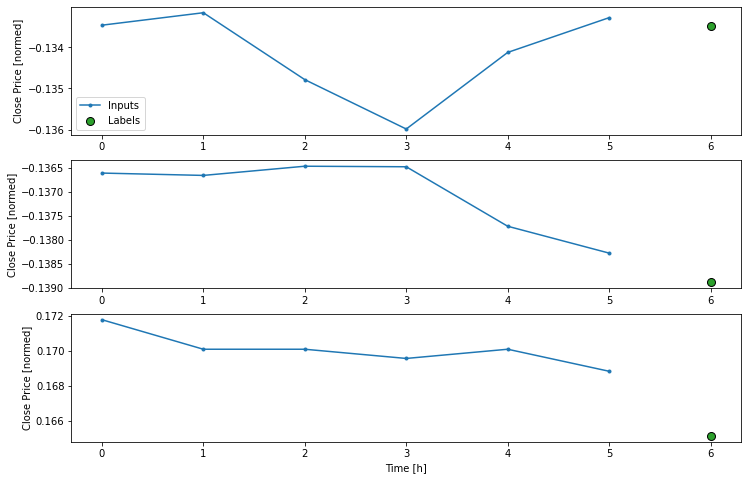

In [ ]:
init_wg.plot()

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close Price'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close Price']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
val_performance = {}
performance = {}

##Performance Baseline Model (Multivariate, Single Step Approach)

Predict the closing price one minute into the future, just by using the current closing price.

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
%%time

baseline = Baseline(label_index=column_indices['Close Price'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
print(val_performance['Baseline'])
print(performance['Baseline'])

13679/13679 [==============================] - 55s 4ms/step - loss: 3.3774e-04 - mean_absolute_error: 0.0099
[0.0003377366519998759, 0.009929880499839783]
[0.0003066982317250222, 0.011553210206329823]
CPU times: user 1min 46s, sys: 26.8 s, total: 2min 13s
Wall time: 1min 20s


In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {val_performance["Baseline"][0]:.5f}')
print(f'Validation Mean Absolute Error: {val_performance["Baseline"][1]:.5f}')
print(f'Test Mean Squared Error: {performance["Baseline"][0]:.5f}')
print(f'Test Mean Absolute Error: {performance["Baseline"][1]:.5f}')

Validation Mean Squared Error: 0.00034
Validation Mean Absolute Error: 0.00993
Test Mean Squared Error: 0.00031
Validation Mean Absolute Error: 0.01155


## Linear Model (Multivariate, Single Step Approach)

Using only the last time step, perform a linear transformation to see if it can do a better job of picking up on the next close price

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 8)
Output shape: (32, 1, 1)


In [ ]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
47876/47876 [==============================] - 354s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0101 - val_loss: 0.0011 - val_mean_absolute_error: 0.0220
Epoch 2/20
47876/47876 [==============================] - 354s 7ms/step - loss: 4.7395e-05 - mean_absolute_error: 0.0032 - val_loss: 6.7895e-04 - val_mean_absolute_error: 0.0167
Epoch 3/20
47876/47876 [==============================] - 367s 8ms/step - loss: 4.7431e-05 - mean_absolute_error: 0.0032 - val_loss: 4.9273e-04 - val_mean_absolute_error: 0.0136
Epoch 4/20
47876/47876 [==============================] - 355s 7ms/step - loss: 5.0539e-05 - mean_absolute_error: 0.0032 - val_loss: 6.0471e-04 - val_mean_absolute_error: 0.0152
Epoch 5/20
13679/13679 [==============================] - 78s 6ms/step - loss: 8.7800e-04 - mean_absolute_error: 0.0188
CPU times: user 44min 2s, sys: 11min 14s, total: 55min 17s
Wall time: 33min 16s


In [ ]:
print(f'Validation Mean Squared Error: {val_performance["Linear"][0]:.5f}')
print(f'Validation Mean Absolute Error: {val_performance["Linear"][1]:.5f}')
print(f'Test Mean Squared Error: {performance["Linear"][0]:.5f}')
print(f'Test Mean Absolute Error: {performance["Linear"][1]:.5f}')

Validation Mean Squared Error: 0.00088
Validation Mean Absolute Error: 0.01878
Test Mean Squared Error: 0.00104
Validation Mean Absolute Error: 0.02689


## Dense Model (Multivariate, Single Step Approach)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', dense(single_step_window.example[0]).shape)

Input shape: (32, 1, 8)
Output shape: (32, 1, 1)


In [ ]:
%%time
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
47876/47876 [==============================] - 255s 5ms/step - loss: 1.5466e-04 - mean_absolute_error: 0.0054 - val_loss: 8.5833e-04 - val_mean_absolute_error: 0.0152
Epoch 2/20
47876/47876 [==============================] - 266s 6ms/step - loss: 6.1778e-05 - mean_absolute_error: 0.0041 - val_loss: 0.0049 - val_mean_absolute_error: 0.0524
Epoch 3/20
13679/13679 [==============================] - 57s 4ms/step - loss: 0.0048 - mean_absolute_error: 0.0523
CPU times: user 20min 17s, sys: 4min 9s, total: 24min 26s
Wall time: 16min 22s


In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {val_performance["Dense"][0]:.5f}')
print(f'Validation Mean Absolute Error: {val_performance["Dense"][1]:.5f}')
print(f'Test Mean Squared Error: {performance["Dense"][0]:.5f}')
print(f'Test Mean Absolute Error: {performance["Dense"][1]:.5f}')

Validation Mean Squared Error: 0.00482
Validation Mean Absolute Error: 0.05233
Test Mean Squared Error: 0.00631
Validation Mean Absolute Error: 0.07420


## Multi-step dense model (Multivariate, Single Step Approach)

The baseline, linear and dense models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a WindowGenerator that will produce batches of X-step inputs and one-step labels

Here, I am just starting with the last two hours (120 minutes), but this can be tuned appropriately

In [ ]:
CONV_WIDTH = 120
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close Price'])

conv_window

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120]
Label column name(s): ['Close Price']

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 120, 8)
Output shape: (32, 1, 1)


In [ ]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
47872/47872 [==============================] - 274s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0197 - val_loss: 0.0035 - val_mean_absolute_error: 0.0358
Epoch 2/20
47872/47872 [==============================] - 274s 6ms/step - loss: 2.4953e-04 - mean_absolute_error: 0.0093 - val_loss: 0.0032 - val_mean_absolute_error: 0.0362
Epoch 3/20
47872/47872 [==============================] - 274s 6ms/step - loss: 1.7807e-04 - mean_absolute_error: 0.0079 - val_loss: 0.0044 - val_mean_absolute_error: 0.0456
Epoch 4/20
13676/13676 [==============================] - 60s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0611
CPU times: user 28min 8s, sys: 5min 16s, total: 33min 24s
Wall time: 23min 9s


In [ ]:
print(f'Validation Mean Squared Error: {val_performance["Multi step dense"][0]:.5f}')
print(f'Validation Mean Absolute Error: {val_performance["Multi step dense"][1]:.5f}')
print(f'Test Mean Squared Error: {performance["Multi step dense"][0]:.5f}')
print(f'Test Mean Absolute Error: {performance["Multi step dense"][1]:.5f}')

Validation Mean Squared Error: 0.00720
Validation Mean Absolute Error: 0.06110
Test Mean Squared Error: 0.00960
Validation Mean Absolute Error: 0.08904


## Convolutional Model (Multivariate, Single Step Approach)

In [ ]:
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close Price'])

conv_window


conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 120, 8)
Output shape: (32, 1, 1)


In [ ]:
%%time
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
47876/47876 [==============================] - 284s 6ms/step - loss: 4.9066e-04 - mean_absolute_error: 0.0075 - val_loss: 0.0016 - val_mean_absolute_error: 0.0203
Epoch 2/20
47876/47876 [==============================] - 338s 7ms/step - loss: 7.9027e-05 - mean_absolute_error: 0.0047 - val_loss: 7.0854e-04 - val_mean_absolute_error: 0.0147
Epoch 3/20
47876/47876 [==============================] - 347s 7ms/step - loss: 6.2127e-05 - mean_absolute_error: 0.0043 - val_loss: 0.0019 - val_mean_absolute_error: 0.0304
Epoch 4/20
13679/13679 [==============================] - 57s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0228
CPU times: user 26min 8s, sys: 8min 50s, total: 34min 59s
Wall time: 25min 50s


In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {val_performance["Conv"][0]:.5f}')
print(f'Validation Mean Absolute Error: {val_performance["Conv"][1]:.5f}')
print(f'Test Mean Squared Error: {performance["Conv"][0]:.5f}')
print(f'Test Mean Absolute Error: {performance["Conv"][1]:.5f}')

Validation Mean Squared Error: 0.00130
Validation Mean Absolute Error: 0.02275
Test Mean Squared Error: 0.00147
Validation Mean Absolute Error: 0.03053


## LSTM (Multivariate, Single Step Approach)

In [ ]:
 wide_window = WindowGenerator(
    input_width=30, label_width=1, shift=1,
    label_columns=['Close Price'])

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # if return_sequences is If False, the default, the layer only returns the output of the final time step, 
    # giving the model time to warm up its internal state before making a single prediction
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
%%time

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
47875/47875 [==============================] - 839s 17ms/step - loss: 8.6039e-04 - mean_absolute_error: 0.0065 - val_loss: 64.7157 - val_mean_absolute_error: 5.2219
Epoch 2/20
47875/47875 [==============================] - 885s 18ms/step - loss: 4.6530e-05 - mean_absolute_error: 0.0039 - val_loss: 67.8432 - val_mean_absolute_error: 5.3884
Epoch 3/20
47875/47875 [==============================] - 865s 18ms/step - loss: 4.1007e-05 - mean_absolute_error: 0.0036 - val_loss: 63.8361 - val_mean_absolute_error: 5.2242
Epoch 4/20
47875/47875 [==============================] - 846s 18ms/step - loss: 3.8624e-05 - mean_absolute_error: 0.0035 - val_loss: 60.8080 - val_mean_absolute_error: 5.0966
Epoch 5/20
47875/47875 [==============================] - 901s 19ms/step - loss: 3.7536e-05 - mean_absolute_error: 0.0034 - val_loss: 60.4886 - val_mean_absolute_error: 5.0807
Epoch 6/20
47875/47875 [==============================] - 915s 19ms/step - loss: 3.6397e-05 - mean_absolute_error: 0.003

In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {val_performance["LSTM"][0]:.5f}')
print(f'Validation Mean Absolute Error: {val_performance["LSTM"][1]:.5f}')
print(f'Test Mean Squared Error: {performance["LSTM"][0]:.5f}')
print(f'Test Mean Absolute Error: {performance["LSTM"][1]:.5f}')

KeyError: ignored

## Further thoughts
* look at how long it takes to run the training steps; probably can subset training further and see how well it does on validation, and then scale to the full training set from there
* *look at the folder time_series_for_DS; it has two good books on implementations for time series*
* *should look back at Shivas' notebooks that have been provided to us to see what information we want to save*
  * I think it would be worth it to get experience using W&B or using MLFlow
* it would be great to use all the previous data for something like LSTM, but I don't know how computationally feasible this approach is


# List of hyperparameters to tune:

* input_width
  * how many minutes should be included in making the predictions?
* label_width
  * how far out do we want to predict? 24 hours, meaning 24 * 60 = 1,440 predictions per minute?
* metric to use
* Single shot predictions where the entire time series is predicted at once, or an autoregressive approach where the model only makes single step predictions and its output is fed back as its input
* batch size
* epochs
* optimizer
* single-shot or autoregressive
* TPU vs. GPU

# Connor thoughts before end of day
* autoregressive is best approach, but not sure we have time to implement this before Tuesday
  * may be better to stick to single step approach, as this autoregressive approach just builds on it and is more complex
* need to re-up on RNN stuff from Tensorflow for RNN
* need to use Eager Execution, and need to have figure out the TFRecords stuff
  * refer back to Shivas' code
* I don't know if TFRecords will actually work here because in the actual code we will be constantly updating the dataset with only a couple extra rows
  * does this mean we'll have to create a new TFRecord shard each time we're getting more data?

# Exploration of Multivaratate, multi-step approach (single shot approach where we're predicting all at once)

### Using the last two hours of data to predict the next 60 minutes

#### This was for Connor playing around and deciding about the prediction approach we plan to take

Using [Tensforflow time series tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_dense)



In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
# how far in the past (in minutes) should we use the data
INPUT_STEPS = 120
# how far in the future 
OUT_STEPS = 60
# saving performance
multi_val_performance = {}
multi_performance = {}
model_times = {}

Total window size: 180
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179]
Label column name(s): None

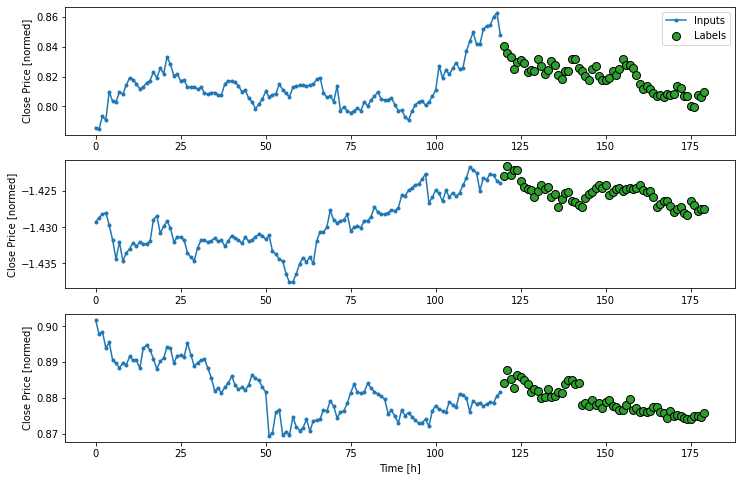

In [ ]:
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

13674/13674 [==============================] - 59s 4ms/step - loss: 10.0352 - mean_absolute_error: 1.0270


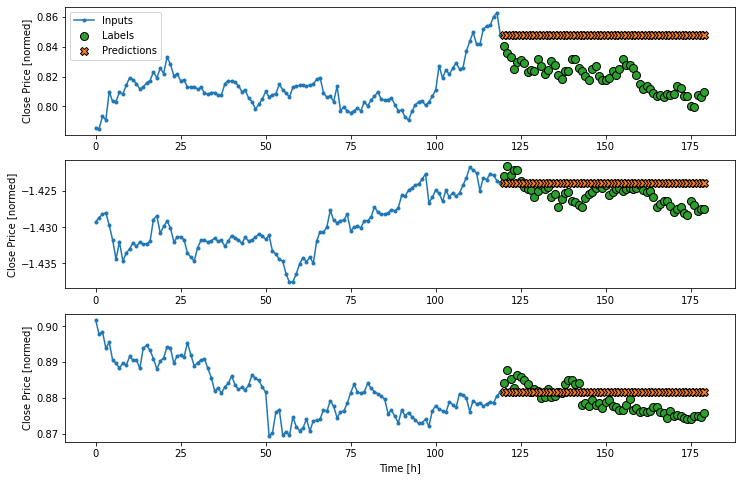

In [ ]:
start = time.time()

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

end = time.time()

model_times['Last'] = (end - start) / 60
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

multi_window.plot(last_baseline)

In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {multi_val_performance["Last"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_val_performance["Last"][1]:.5f}')
print(f'Test Mean Squared Error: {multi_performance["Last"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_performance["Last"][1]:.5f}')
print(f'Performance time (minutes): {model_times["Last"]}')

Validation Mean Squared Error: 10.03517
Validation Mean Absolute Error: 1.02695
Test Mean Squared Error: 18.06994
Validation Mean Absolute Error: 1.27480
Performance time (minutes): 0.0004763921101888021


In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

Epoch 1/20
47871/47871 [==============================] - 304s 6ms/step - loss: 0.5308 - mean_absolute_error: 0.2527 - val_loss: 7.7410 - val_mean_absolute_error: 0.9086
Epoch 2/20
47871/47871 [==============================] - 278s 6ms/step - loss: 0.5283 - mean_absolute_error: 0.2505 - val_loss: 7.7310 - val_mean_absolute_error: 0.9071
Epoch 3/20
47871/47871 [==============================] - 311s 6ms/step - loss: 0.5283 - mean_absolute_error: 0.2505 - val_loss: 7.7577 - val_mean_absolute_error: 0.9116
Epoch 4/20
13674/13674 [==============================] - 63s 5ms/step - loss: 7.7763 - mean_absolute_error: 0.9106


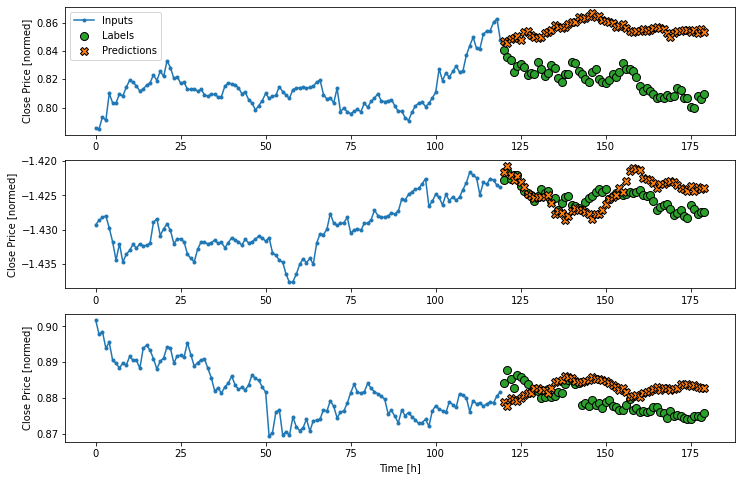

In [ ]:
start = time.time()

history = compile_and_fit(multi_linear_model, multi_window)

end = time.time()

model_times['Linear'] = (end - start) / 60
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {multi_val_performance["Linear"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_val_performance["Linear"][1]:.5f}')
print(f'Test Mean Squared Error: {multi_performance["Linear"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_performance["Linear"][1]:.5f}')
print(f'Performance time (minutes): {model_times["Linear"]}')

Validation Mean Squared Error: 7.77625
Validation Mean Absolute Error: 0.91061
Test Mean Squared Error: 11.82494
Validation Mean Absolute Error: 1.08417
Performance time (minutes): 19.569804708162945


In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


Epoch 1/20
47871/47871 [==============================] - 495s 10ms/step - loss: 0.5091 - mean_absolute_error: 0.2407 - val_loss: 8.5225 - val_mean_absolute_error: 1.1552
Epoch 2/20
47871/47871 [==============================] - 486s 10ms/step - loss: 0.5059 - mean_absolute_error: 0.2388 - val_loss: 8.8108 - val_mean_absolute_error: 1.1344
Epoch 3/20
13674/13674 [==============================] - 77s 6ms/step - loss: 8.8997 - mean_absolute_error: 1.1526


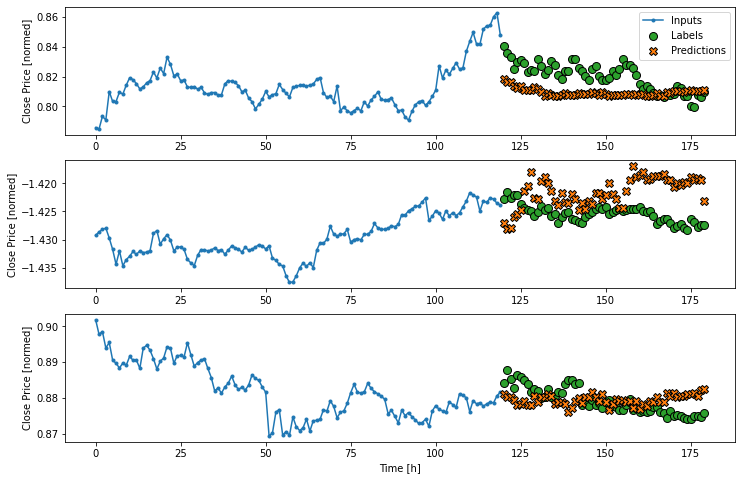

In [ ]:
start = time.time()

history = compile_and_fit(multi_dense_model, multi_window)


end = time.time()

model_times['Dense'] = (end - start) / 60
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {multi_val_performance["Dense"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_val_performance["Dense"][1]:.5f}')
print(f'Test Mean Squared Error: {multi_performance["Dense"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_performance["Dense"][1]:.5f}')
print(f'Performance time (minutes): {model_times["Dense"]}')

Validation Mean Squared Error: 8.89966
Validation Mean Absolute Error: 1.15260
Test Mean Squared Error: 13.73278
Validation Mean Absolute Error: 1.32456
Performance time (minutes): 24.528167057037354


In [ ]:
CONV_WIDTH = 10
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

Epoch 1/20
47871/47871 [==============================] - 418s 9ms/step - loss: 0.4891 - mean_absolute_error: 0.2338 - val_loss: 6.7747 - val_mean_absolute_error: 1.0373
Epoch 2/20
47871/47871 [==============================] - 409s 9ms/step - loss: 0.4862 - mean_absolute_error: 0.2319 - val_loss: 6.8839 - val_mean_absolute_error: 1.1032
Epoch 3/20
13674/13674 [==============================] - 71s 5ms/step - loss: 6.8646 - mean_absolute_error: 0.9257


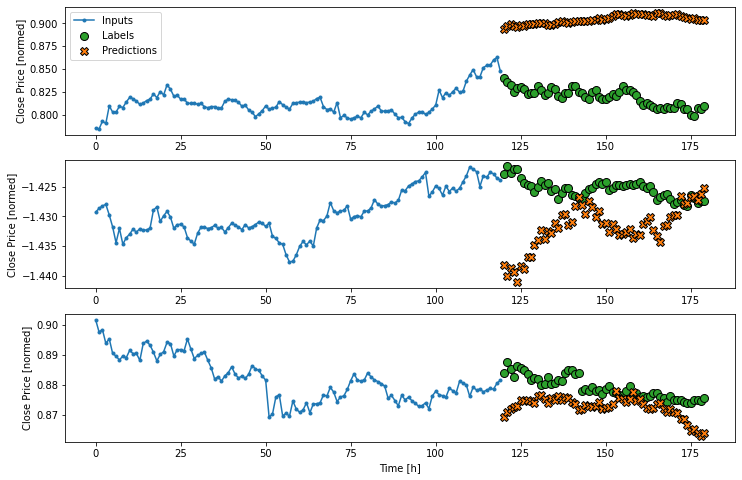

In [ ]:
start = time.time()

history = compile_and_fit(multi_conv_model, multi_window)

end = time.time()

model_times['Conv'] = (end - start) / 60
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {multi_val_performance["Conv"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_val_performance["Conv"][1]:.5f}')
print(f'Test Mean Squared Error: {multi_performance["Conv"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_performance["Conv"][1]:.5f}')
print(f'Performance time (minutes): {model_times["Conv"]}')

Validation Mean Squared Error: 6.86457
Validation Mean Absolute Error: 0.92571
Test Mean Squared Error: 10.97349
Validation Mean Absolute Error: 1.12096
Performance time (minutes): 21.073287228743236


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

Epoch 1/20
47871/47871 [==============================] - 2773s 58ms/step - loss: 0.4780 - mean_absolute_error: 0.2262 - val_loss: 38.1560 - val_mean_absolute_error: 3.3037
Epoch 2/20
47871/47871 [==============================] - 2738s 57ms/step - loss: 0.4712 - mean_absolute_error: 0.2230 - val_loss: 40.0991 - val_mean_absolute_error: 3.4168
Epoch 3/20
13674/13674 [==============================] - 228s 17ms/step - loss: 42.9281 - mean_absolute_error: 3.5370


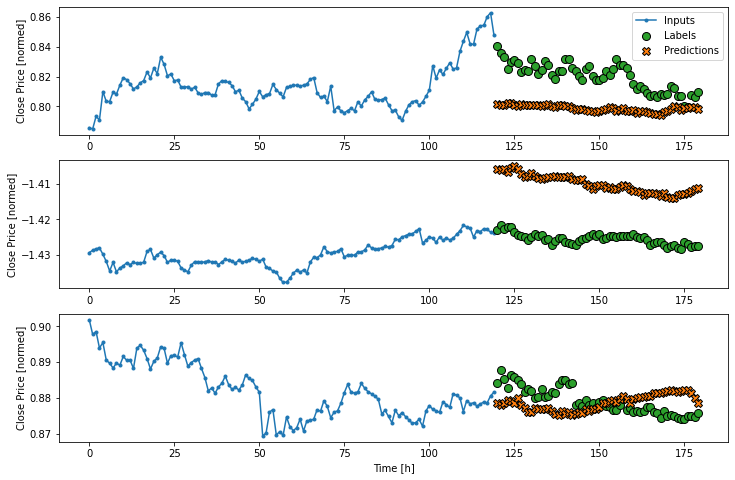

In [ ]:
start = time.time()

history = compile_and_fit(multi_lstm_model, multi_window)

end = time.time()

model_times['LSTM'] = (end - start) / 60
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
# Colab throws invalid syntax error if you use ' instead of " for getting key of dictionary
print(f'Validation Mean Squared Error: {multi_val_performance["LSTM"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_val_performance["LSTM"][1]:.5f}')
print(f'Test Mean Squared Error: {multi_performance["LSTM"][0]:.5f}')
print(f'Validation Mean Absolute Error: {multi_performance["LSTM"][1]:.5f}')
print(f'Performance time (minutes): {model_times["LSTM"]}')

Validation Mean Squared Error: 42.92813
Validation Mean Absolute Error: 3.53698
Test Mean Squared Error: 55.43489
Validation Mean Absolute Error: 5.16351
Performance time (minutes): 139.9259490052859


In [ ]:
print(model_times)

{'Last': 0.0004763921101888021, 'Linear': 19.569804708162945, 'Dense': 24.528167057037354, 'Conv': 21.073287228743236, 'LSTM': 139.9259490052859}


In [ ]:
print(multi_val_performance)

{'Last': [10.035171508789062, 1.0269510746002197], 'Linear': [7.776251792907715, 0.9106128215789795], 'Dense': [8.899662017822266, 1.1525970697402954], 'Conv': [6.864565372467041, 0.9257062077522278], 'LSTM': [42.928131103515625, 3.5369796752929688]}


In [ ]:
print(multi_performance)

{'Last': [18.06993865966797, 1.2747983932495117], 'Linear': [11.824936866760254, 1.0841695070266724], 'Dense': [13.732778549194336, 1.3245596885681152], 'Conv': [10.973487854003906, 1.12096107006073], 'LSTM': [55.43489456176758, 5.163509845733643]}
